# VQVAE for Fashion MNIST

## Principle of VQ-VAE

### A word on Autoencoders

VAE are using Autoencoder framework [(Gianni FRANCHI's DeepLearning Course)](https://perso.ensta-paris.fr/%7Emanzaner/Cours/ROB313/ROB313_DeepLearning2.pdf):
- An encoder takes an input X an maps it to a hidden representation
- A decoder takes this hidden representation and tries to reconstruct the input


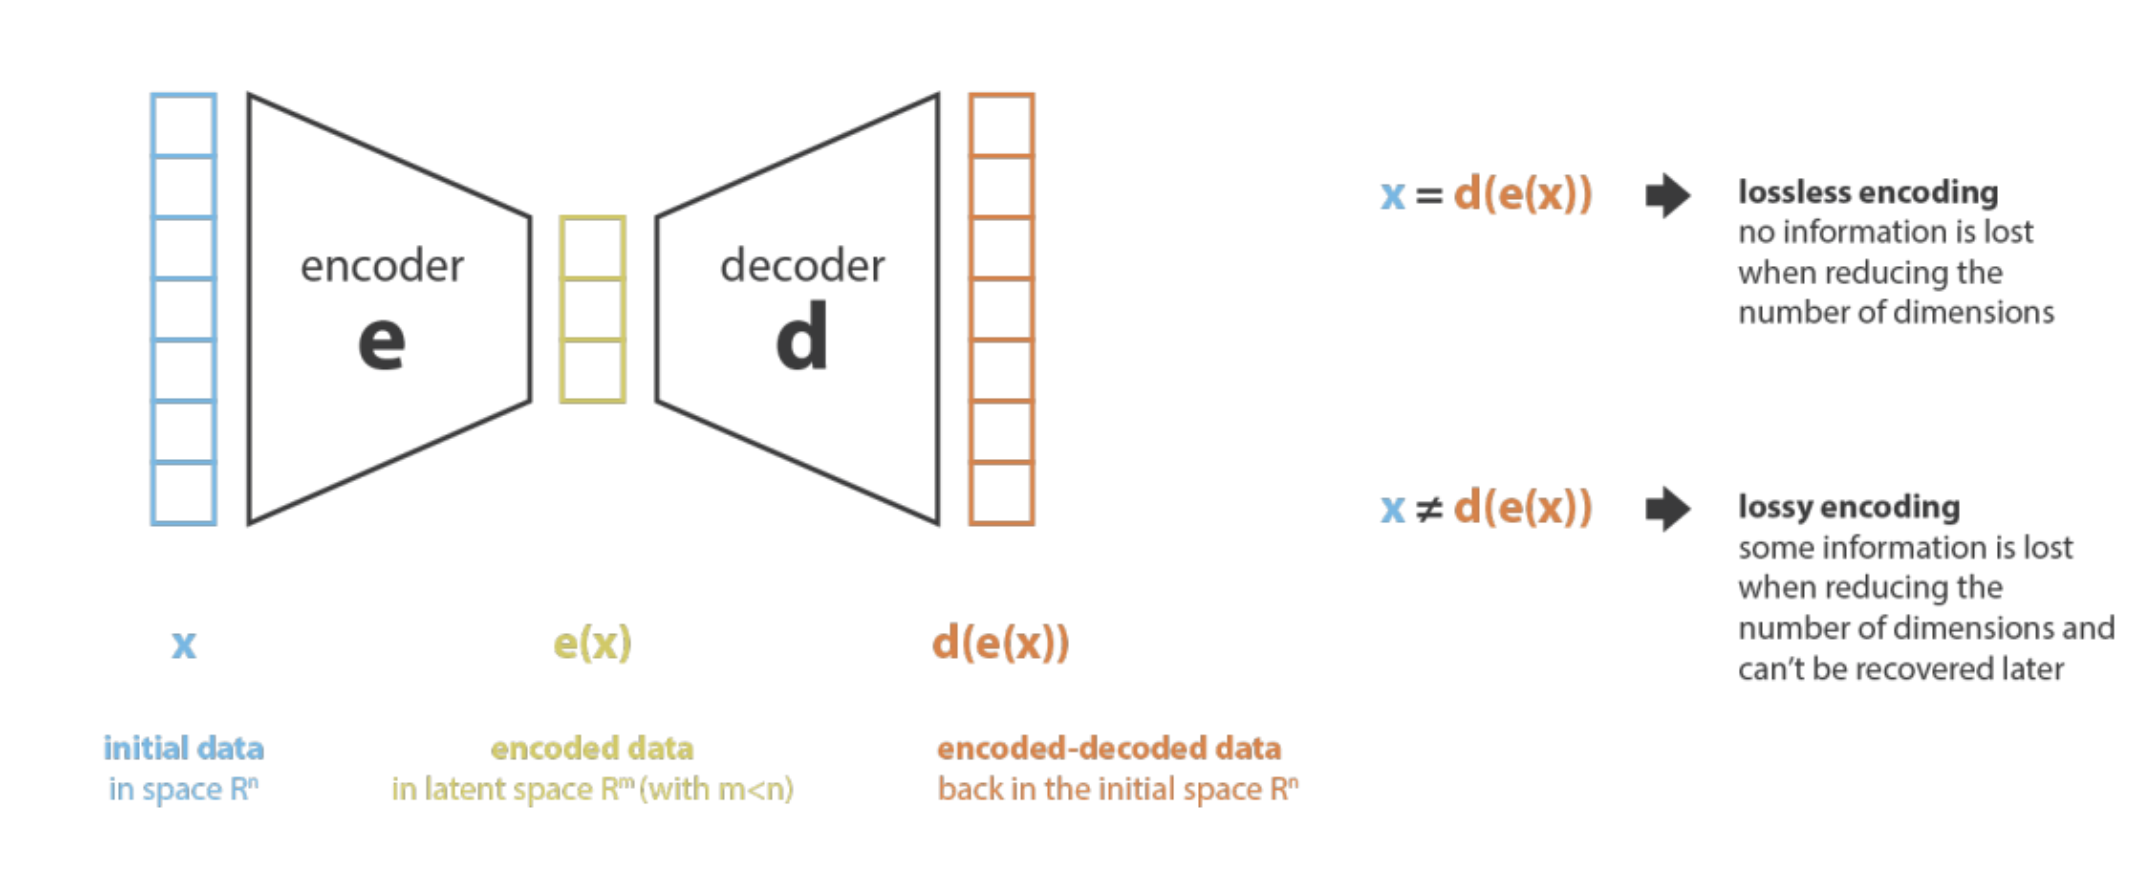


- Encoder: generally a pre-trained DNN (ResNet)
- Decoder: the decoder is smaller, may skip connection to improve training, may have multi resolution feature maps
- Loss:    
$loss=\lVert x-\hat{x}\lVert^2 = \lVert x-d(z) \lVert^2 = \lVert x-d(e(x))\lVert^2$

An autoencoder cannot generate data, it only code and decode it.

Autoencoders are used for:
- Converting input to lower dimension
- Representation learning (Mask autoencoders)
- De-noising


### Why we need a Variational AE ?

- Autoencoders will tend to push data point far from each other in the latent space. This eeffectively reduces the reconstruction loss but does not guarantee all point in the latent space will generate valid images.

- We cannot generate new variation of the datapoints since we do not have any knowledge of points' distribution

Instead of representing each input data as a point in a latent space, we represent it as a distribution:

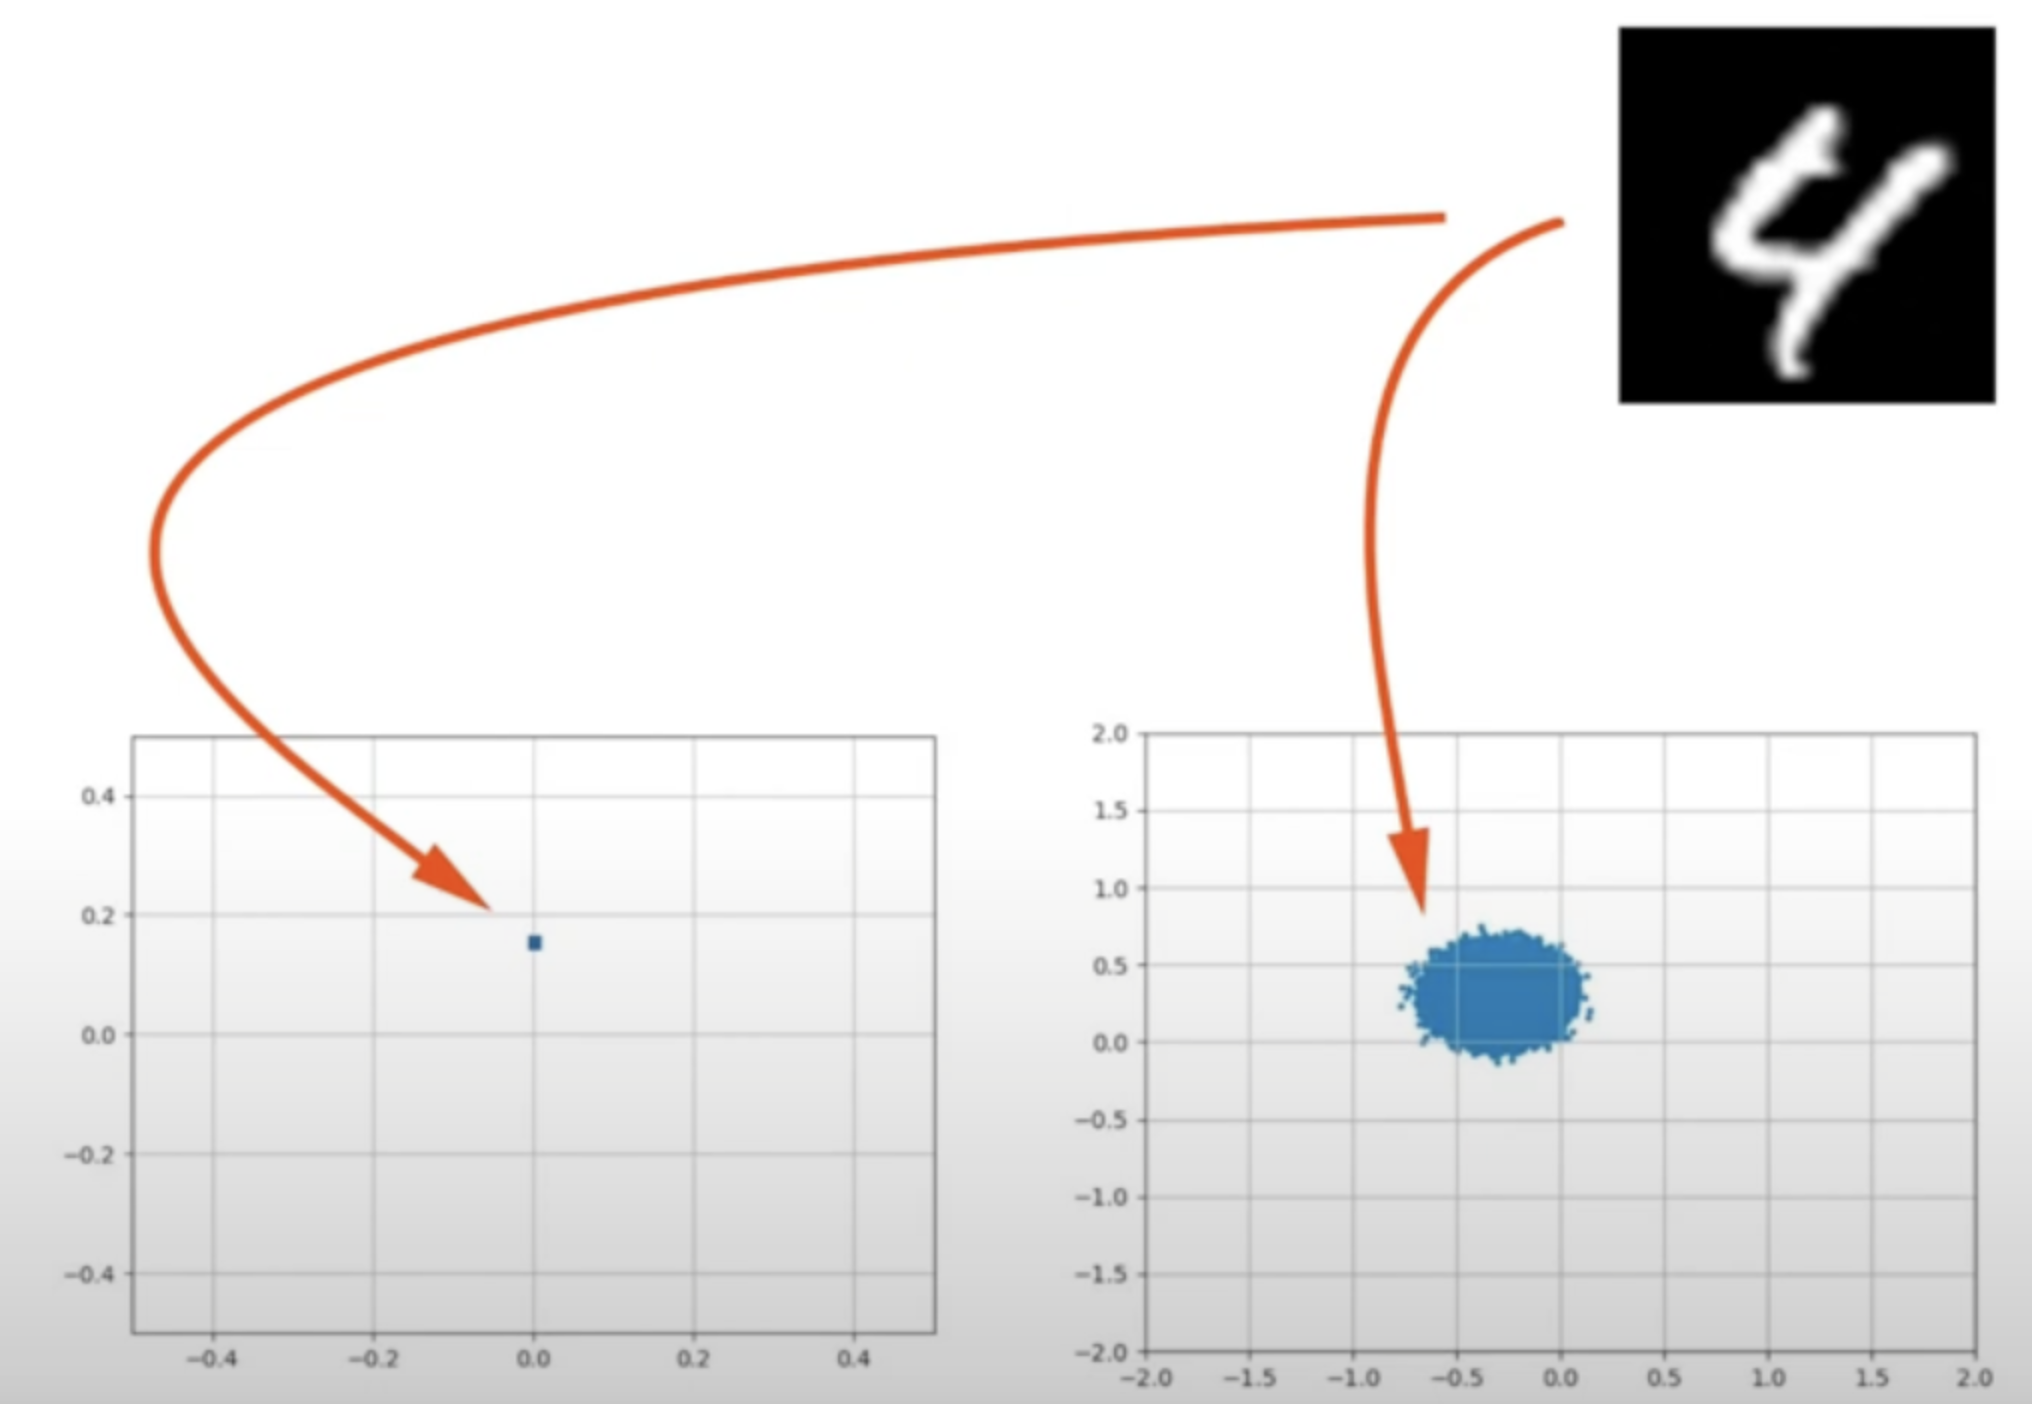

To avoid the distribution to shrink into small values, we must constraint the distribution:
- We should disable distributions to move far apart from one another
- VAE Should not collapse encoder distributions to singular point as we need wide distributions to capture entire latent space
- Ensure that distributions have higher variance and hence disable the network to collapse distribution to a point

=> We use KL Divergence between the distribution and standard gaussian 

Let consider z a point in the latent space generating x:

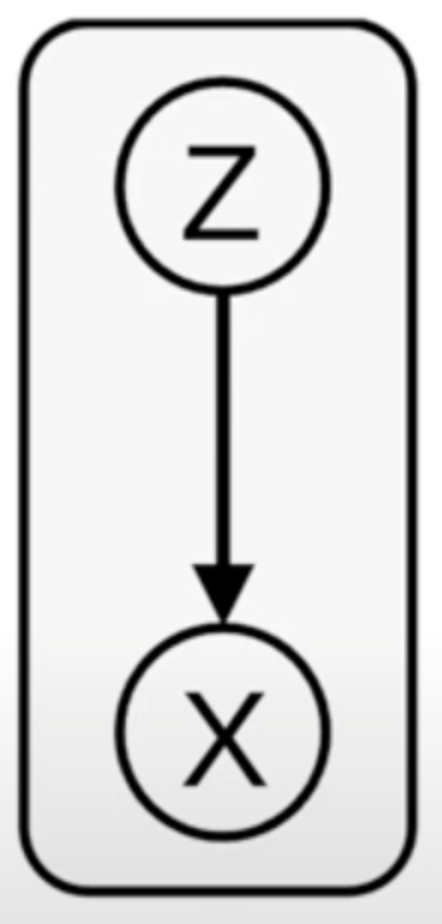

The data generation will be:
- Sample a point in the latent space from a prior p(z)
- Generate a data point by sampling point from distribution p(x|z)

**Assumptions**:
- p(z) is a standard gaussian
- p(x|z) is a gaussian distribution whose mean is defined by function f. (will be approxcimated through the decoder)

x doesnt give any information on z, we need p(z|x):

$p(z|x)=\frac{p(x|z)p(z)}{p(x)}$

but $p(x)=\sum_{z_t}{p(x|z_t)p(z_t)}$ is computationally expensive.

We find an approximation:

$p(z|x) \sim q(z|x) = \mathcal{N}(\mu,\,\sigma^{2})$

Then, we want to minimize the distance between q(z|x) and p(z|x):

$minKL(q(z|x), p(z|x))$

**Minimization of KL divergence:**

$\sum{q(z|x)log(\frac{q(z|x)}{p(z|x)})}$

$\sum{q(z|x)log(q(z|x))} - \sum{log(p(z|x))}$

$\sum{q(z|x)log(q(z|x))} - \sum{log(\frac{p(x|z)p(z)}{p(x)})}$

$\sum{q(z|x)log(q(z|x))} - \sum{q(z|x)log(p(x|z))} - \sum{q(z|x)log(p(z))} + \sum{q(z|x)log(p(x))}$



$\sum{q(z|x)log(p(x))} = cte$, therefore:

we want to minimize:

$\sum{q(z|x)log(q(z|x))} - \sum{q(z|x)log(p(x|z))} - \sum{q(z|x)log(p(z))}$

$\sum{q(z|x)log(\frac{q(z|x)}{p(z)})} - \sum{q(z|x)log(p(x|z))}$

$minKL(q(z|x), p(z)) - E_{z \sim q(z|x)} (log(p(x|z)))$

Finally, we get the formulation:

$minKL(q(z|x), p(z)) + E_{z \sim q(z|x)} \frac{1}{2c}\lVert x-f(z) \lVert^2$

KL Divergence loss + Reconstruction loss

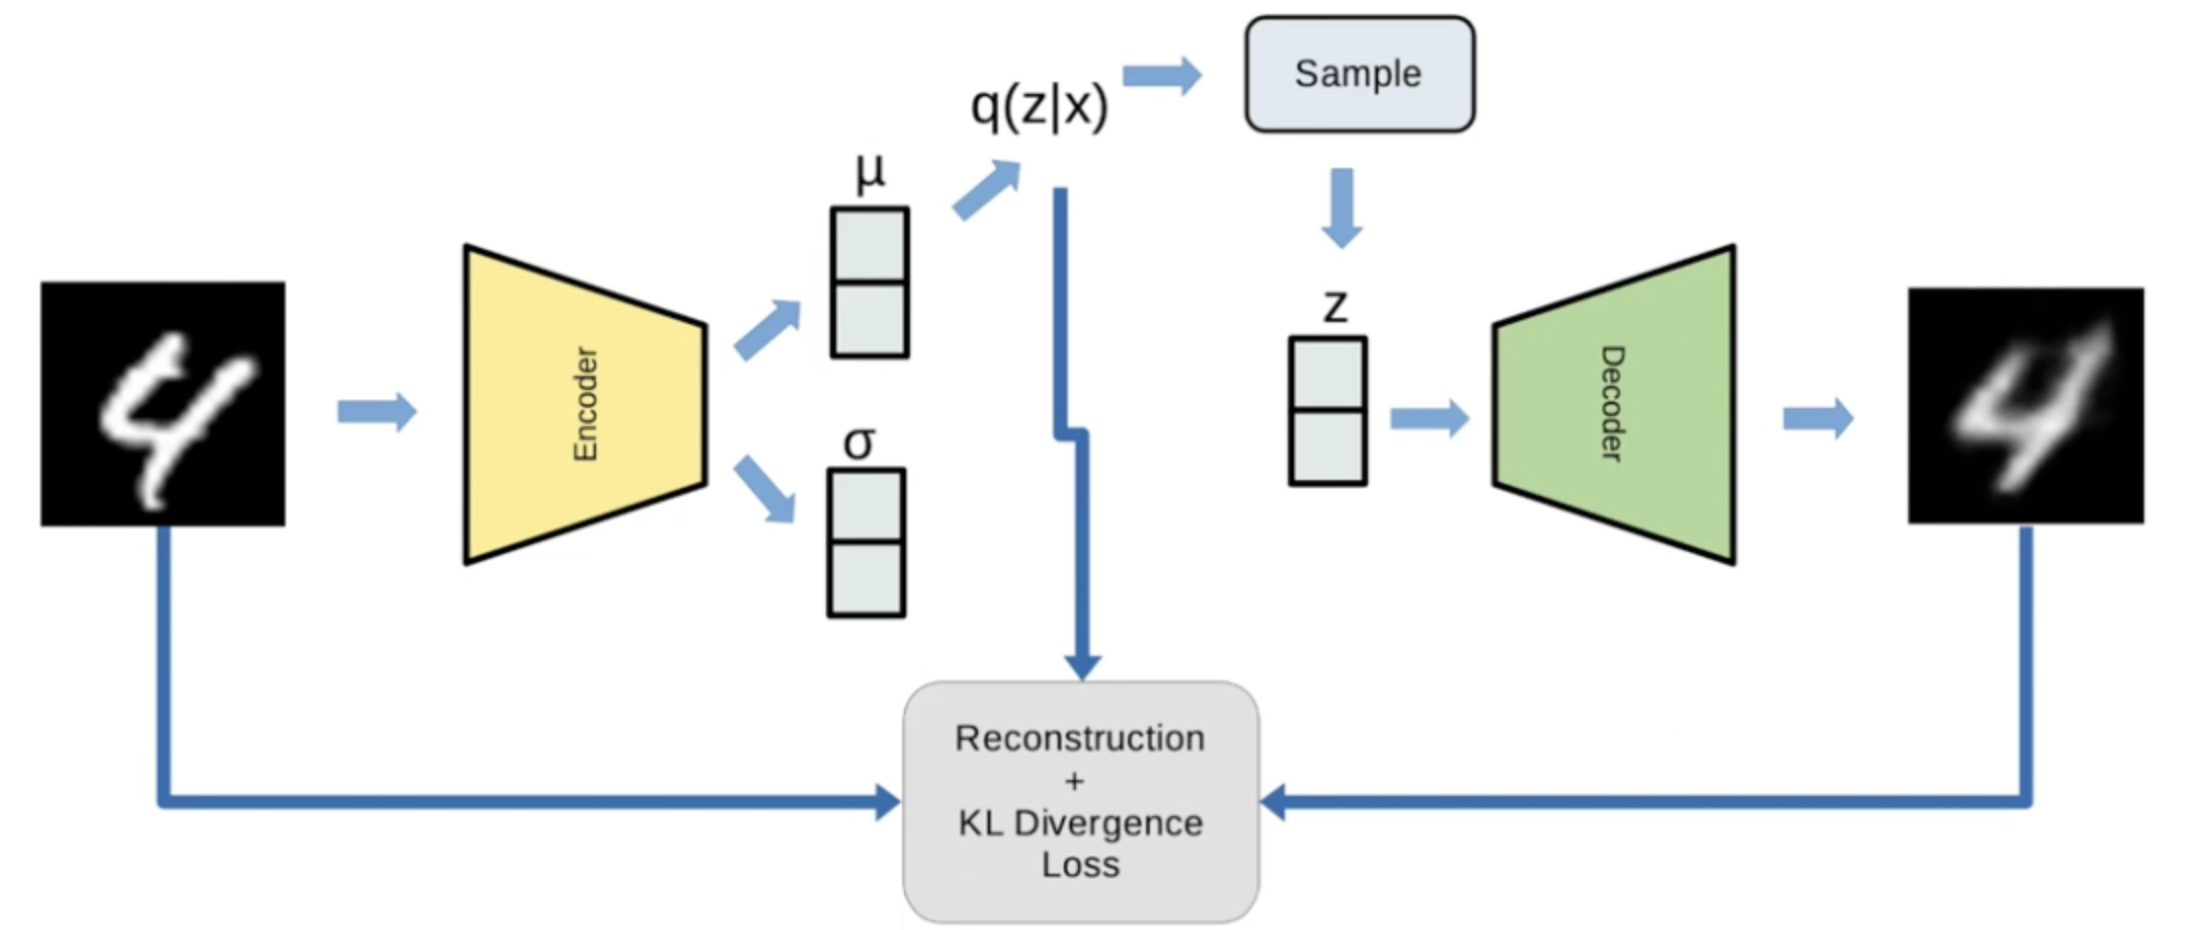

### VQ - VAE vs VAE

- Lower dimensional latent space becomes weak for a string decoder and VAE could collapse into generating images that look like mean representation of data
- If we increase the dimensionality to avoid the first point, we are requiring VAE to ensure all points sampled from this higher dimensional latent space generate valid image, which can be difficult ...
- While latent space allow to continuously encode images, in real world, data are not continuously interpretable. Either a photo is a cat or a person, interpolation between class can make no sense at all.

- In VQ-VAE, instead of learning a continuous representation of space, we learn a **discrete representation of space**

### VQ - VAE Architecture

#### Encoder side

VQ VAE architecture is similar to the VAE one. Is added only a Codebook (k embedded vectors):
- Encoder: block of convolutional layers

For each vector in feature map, we find the nearest codebook vector, we replace it with that codebook vector.

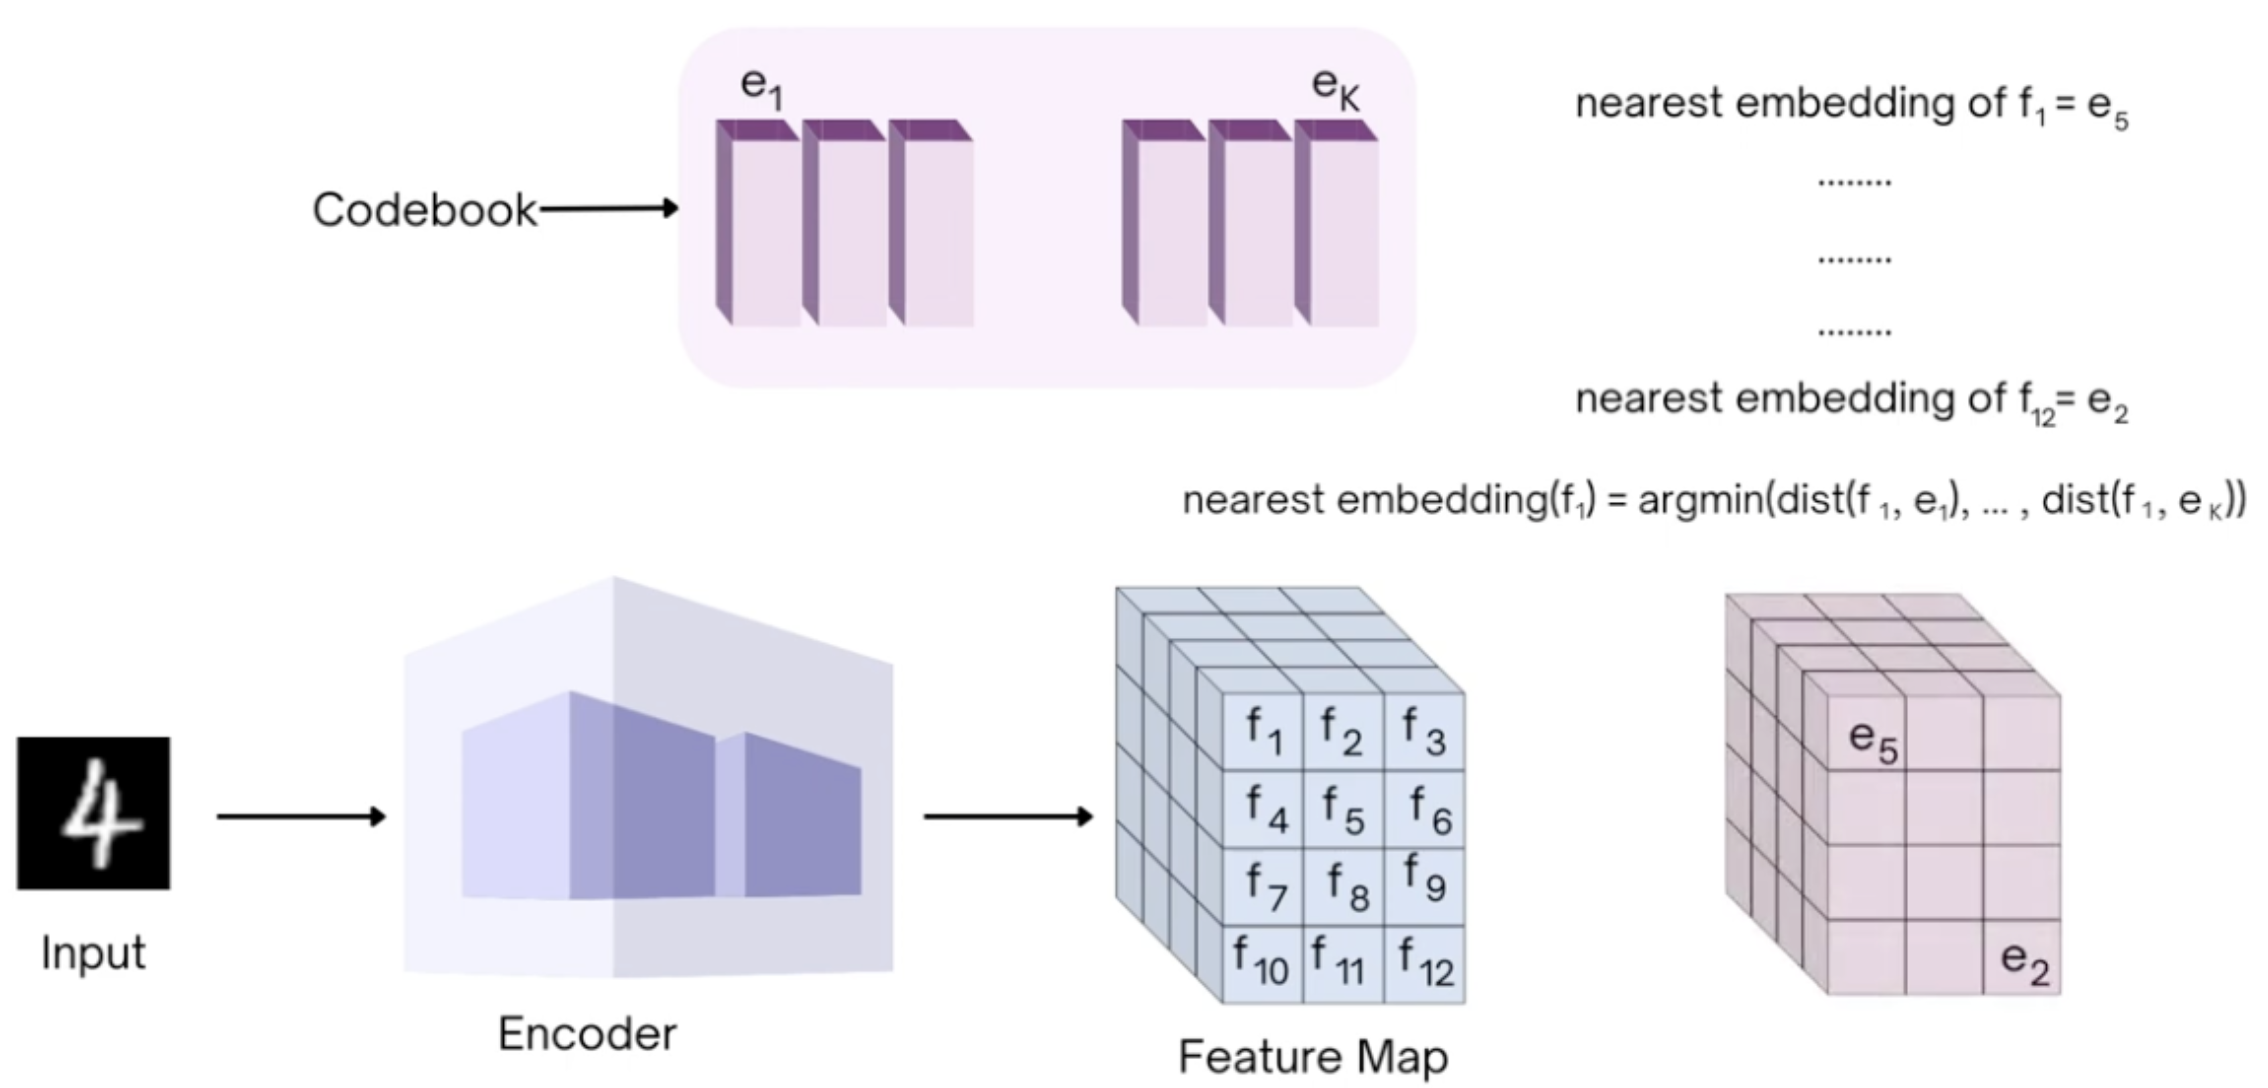


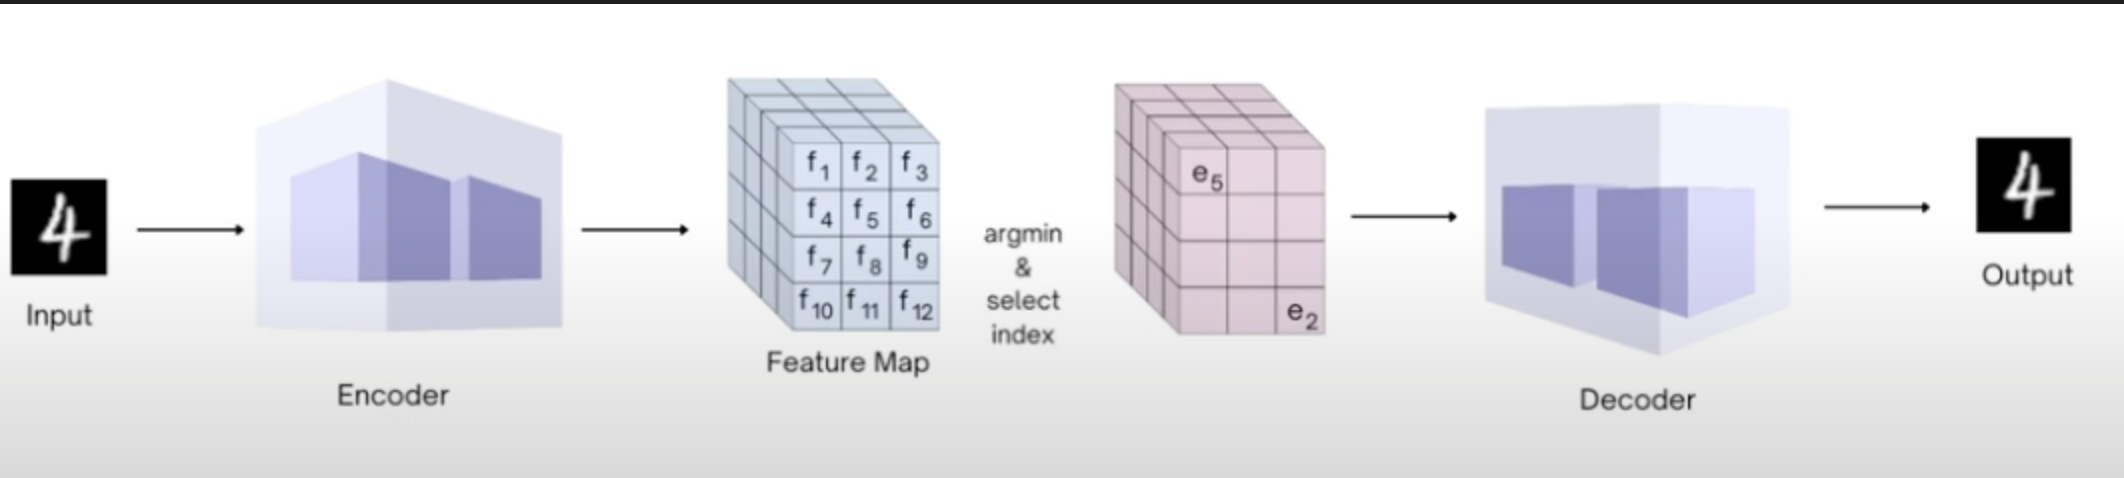

#### Back propagation

When we inspect the gradient at any layer before the decoder, they would be 0 as we found the nearest ebedding vectors. We have to bypass the embedding block.

We pass A to a node which uses a non-differentiable function to compute the value of B.
Attach ensure the variable is separate from the computational graph and no gradient is passed along that node during back propagation.


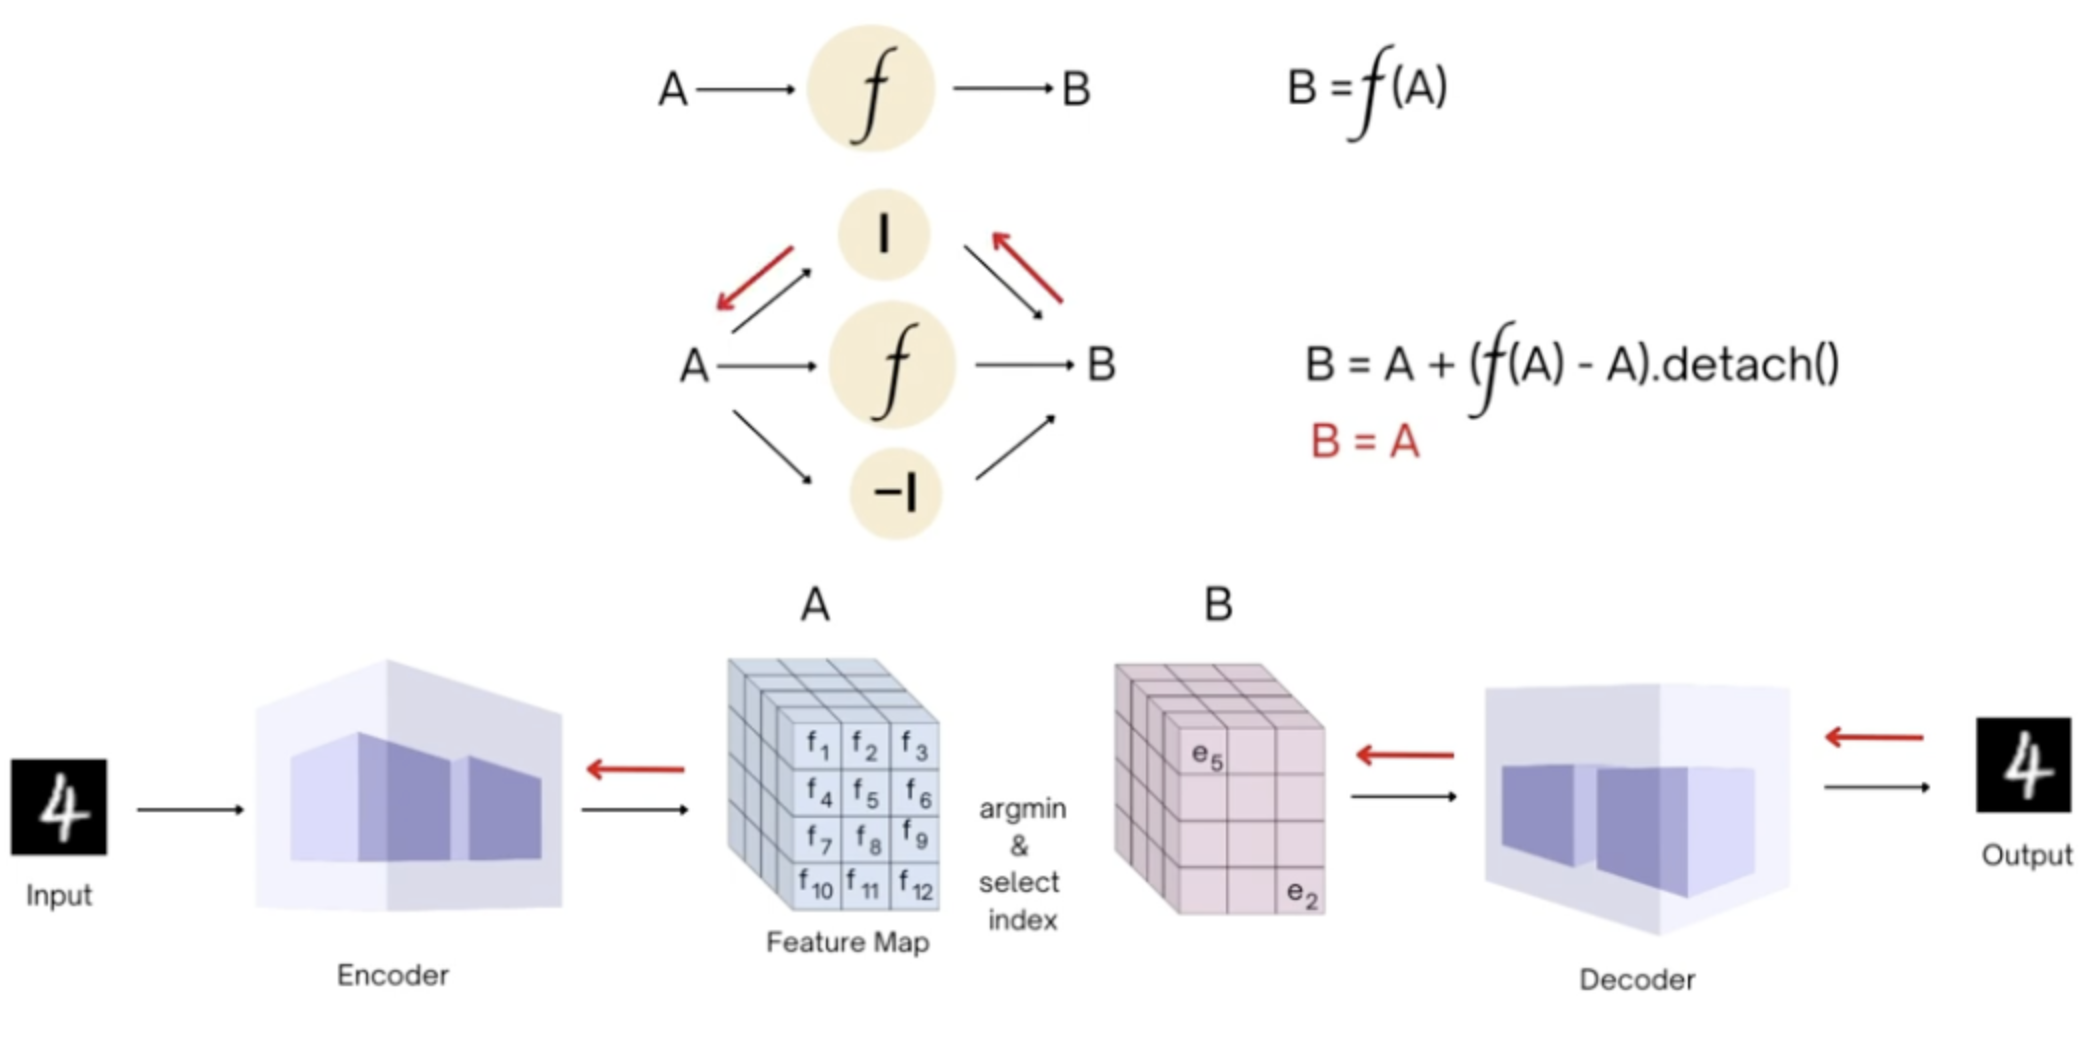

#### Since backprop don't affect embedding vectors, how to update them ?

1- 
We can represent the embedding vector in the latent space and look at them as there are centroids.
The quantization operation can be seen as clustering the encoder outputs into K clusters.
We can then update embedding vectors by bringing them closer to the encoded points (mean of the cluster)

Use of codebook loss:
$\lVert sg[z_e(x)] - e\lVert_2^2$

2-
We can treat the embeddings as constant and bring the encoded points closer to them.
This loss is meant to ensure the encoder commits to an embedding and prevents the encoder outputs from fluctuating between different code vectors.

Use of commitment loss:
$\lVert z_e(x) - sg[e]\lVert_2^2$

=> We add a scalar $\beta$ that represents the relative importance between the two losses: either we adapt the codebook to the encoder or the encoder to the codebook.

#### Summary of the losses

Reconstruction Loss: MSE

Codebook Loss: $\lVert sg[z_e(x)] - e\lVert_2^2$

Commitment Loss: $\lVert z_e(x) - sg[e]\lVert_2^2$

KL Loss: $\sum q(z|x)log(\frac{q(z|x)}{p(z)})$


For VQVAE, p(z) is uniform, so the predicted distribution is a one-hot vector, meaning the KL Loss will have only one term which will evaluate to $log(k)$ => We can ignore it as this is a constant


$L=log(p(x|z_q(x))) + \lVert sg[z_e(x)] - e\lVert_2^2 + \beta \lVert z_e(x) - sg[e]\lVert_2^2$

In [61]:
from datasets import load_dataset, load_from_disk
import random
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torchvision import transforms, datasets
from torchvision.utils import make_grid

In [62]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# MacOS ARM-based CPU: mps
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

# Reproductibility
torch.manual_seed(53)
random.seed(53)
np.random.seed(53)
# Dataset parameters
batch_size = 32

## Create Dataset

In [63]:
dataset = load_dataset("zalando-datasets/fashion_mnist")

# Many Neural Network work better when the input values are centered around 0.
# .ToTensor is used to convert image values to [0, 1]
# lambda function maps [0, 1] to [-1, 1]
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
val_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_train)

### Visualize dataset

In [64]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=0)

x_train_var = np.var(train_dataset.train_data.numpy() / 255.0)


batch_image = next(iter(train_dataloader))[0]
batch_image.shape

/Users/taoguinot/.pyenv/versions/3.12.0/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([32, 1, 28, 28])

In [65]:
def normalize_im(images):
    shape = images.shape
    images = images.view(shape[0], -1)
    images -= images.min(1, keepdim=True)[0]
    images /= images.max(1, keepdim=True)[0]
    return images.view(shape)

def show_images(batch):
    plt.imshow(torch.permute(make_grid(normalize_im(batch)), (1,2,0)))
    plt.show()

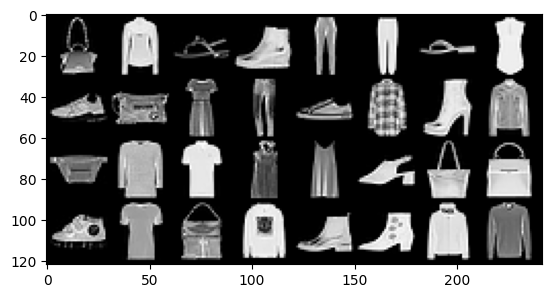

In [66]:
show_images(batch_image[:])

# VQVAE Implementation

In [67]:
!pip install -qq torch

In [68]:
import torch.nn as nn
import torch

In [69]:
batch_size = 32
n_updates = 5000
n_hiddens = 256
n_residual_hiddens = 32
n_residual_layers = 2
embedding_dim = 64
n_embeddings = 16
beta = .25
learning_rate = 3e-4
log_interval = 50

In [70]:
class VectorQuantizer(nn.Module):
    """
    Inputs:
    - n_embeddings : number of embeddings
    - embedding_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, n_embedding, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_embedding = n_embedding
        self.embedding_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_embedding, self.embedding_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_embedding, 1.0 / self.n_embedding)

    def forward(self, z):

        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.embedding_dim)

        d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - 2 * \
            torch.matmul(z_flattened, self.embedding.weight.t())

        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_embedding).to(DEVICE)
        min_encodings.scatter_(1, min_encoding_indices, 1)

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        # reshape back to match original input shape
        z_q = z_q.permute(0, 3, 1, 2).contiguous()

        return loss, z_q, perplexity, min_encodings, min_encoding_indices


In [71]:
import torch.nn.functional as F

class ResidualLayer(nn.Module):
    """
    One residual layer inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    """

    def __init__(self, in_dim, h_dim, res_h_dim):
        super(ResidualLayer, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_dim, res_h_dim, kernel_size=3,
                      stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(res_h_dim, h_dim, kernel_size=1,
                      stride=1, bias=False)
        )

    def forward(self, x):
        x = x + self.res_block(x)
        return x


class ResidualStack(nn.Module):
    """
    A stack of residual layers inputs:
    - in_dim : the input dimension
    - h_dim : the hidden layer dimension
    - res_h_dim : the hidden dimension of the residual block
    - n_res_layers : number of layers to stack
    """

    def __init__(self, in_dim, h_dim, res_h_dim, n_res_layers):
        super(ResidualStack, self).__init__()
        self.n_res_layers = n_res_layers
        self.stack = nn.ModuleList(
            [ResidualLayer(in_dim, h_dim, res_h_dim)]*n_res_layers)

    def forward(self, x):
        for layer in self.stack:
            x = layer(x)
        x = F.relu(x)
        return x


In [72]:
class Encoder(nn.Module):
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Encoder, self).__init__()
        kernel = 4
        stride = 2
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_dim, h_dim // 2, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim // 2, h_dim, kernel_size=kernel,
                      stride=stride, padding=1),
            nn.ReLU(),
            nn.Conv2d(h_dim, h_dim, kernel_size=kernel-1,
                      stride=stride-1, padding=1),
            ResidualStack(
                h_dim, h_dim, res_h_dim, n_res_layers)

        )

    def forward(self, x):
        return self.conv_stack(x)


In [73]:
class Decoder(nn.Module):
    def __init__(self, in_dim, h_dim, n_res_layers, res_h_dim):
        super(Decoder, self).__init__()
        kernel = 4
        stride = 2

        self.inverse_conv_stack = nn.Sequential(
            nn.ConvTranspose2d(
                in_dim, h_dim, kernel_size=kernel-1, stride=stride-1, padding=1),
            ResidualStack(h_dim, h_dim, res_h_dim, n_res_layers),
            nn.ConvTranspose2d(h_dim, h_dim // 2,
                               kernel_size=kernel, stride=stride, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim//2, 3, kernel_size=kernel,
                               stride=stride, padding=1)
        )

    def forward(self, x):
        return self.inverse_conv_stack(x)



In [74]:

class VQVAE(nn.Module):
    def __init__(self, h_dim, res_h_dim, n_res_layers,
                 n_embeddings, embedding_dim, beta, save_img_embedding_map=False):
        super(VQVAE, self).__init__()
        # encode image into continuous latent space
        self.encoder = Encoder(1, h_dim, n_res_layers, res_h_dim)
        self.pre_quantization_conv = nn.Conv2d(
            h_dim, embedding_dim, kernel_size=1, stride=1)
        # pass continuous latent vector through discretization bottleneck
        self.vector_quantization = VectorQuantizer(
            n_embeddings, embedding_dim, beta)
        # decode the discrete latent representation
        self.decoder = Decoder(embedding_dim, h_dim, n_res_layers, res_h_dim)

        if save_img_embedding_map:
            self.img_to_embedding_map = {i: [] for i in range(n_embeddings)}
        else:
            self.img_to_embedding_map = None

    def forward(self, x):

        z_e = self.encoder(x)

        z_e = self.pre_quantization_conv(z_e)
        embedding_loss, z_q, perplexity, _, _ = self.vector_quantization(
            z_e)
        x_hat = self.decoder(z_q)


        return embedding_loss, x_hat, perplexity


In [75]:
import torch.optim as optim
model = VQVAE(n_hiddens, n_residual_hiddens,
              n_residual_layers, n_embeddings, embedding_dim, beta).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

model.train()
results = {
    'n_updates': 0,
    'recon_errors': [],
    'loss_vals': [],
    'perplexities': [],
}

In [76]:
def train():
    for i in range(n_updates):
        (x, _) = next(iter(train_dataloader))
        x = x.to(DEVICE)
        optimizer.zero_grad()

        embedding_loss, x_hat, perplexity = model(x)
        recon_loss = torch.mean((x_hat - x)**2) / x_train_var
        loss = recon_loss + embedding_loss

        loss.backward()
        optimizer.step()

        results["recon_errors"].append(recon_loss.cpu().detach().numpy())
        results["perplexities"].append(perplexity.cpu().detach().numpy())
        results["loss_vals"].append(loss.cpu().detach().numpy())
        results["n_updates"] = i

        if i % log_interval == 0:
            print('Update #', i, 'Recon Error:',
                    np.mean(results["recon_errors"][-log_interval:]),
                    'Loss', np.mean(results["loss_vals"][-log_interval:]),
                    'Perplexity:', np.mean(results["perplexities"][-log_interval:]))



In [77]:
train()

Update # 0 Recon Error: 5.606446 Loss 5.610123 Perplexity: 2.901166
Update # 50 Recon Error: 3.1663134 Loss 7.950553 Perplexity: 2.363289
Update # 100 Recon Error: 1.3941189 Loss 25.39759 Perplexity: 2.4447234
Update # 150 Recon Error: 1.1407238 Loss 8.828837 Perplexity: 2.6868029
Update # 200 Recon Error: 1.0633268 Loss 22.625147 Perplexity: 2.639099
Update # 250 Recon Error: 0.95725816 Loss 17.8042 Perplexity: 3.0333068
Update # 300 Recon Error: 0.86299103 Loss 11.236972 Perplexity: 3.4359937
Update # 350 Recon Error: 0.7960406 Loss 8.418818 Perplexity: 3.843969
Update # 400 Recon Error: 0.7605499 Loss 7.601028 Perplexity: 4.51819
Update # 450 Recon Error: 0.77892226 Loss 6.796026 Perplexity: 4.7837625
Update # 500 Recon Error: 0.735438 Loss 5.45023 Perplexity: 4.9937434
Update # 550 Recon Error: 0.6954381 Loss 4.608276 Perplexity: 5.6490326
Update # 600 Recon Error: 0.6696235 Loss 3.485527 Perplexity: 6.1373405
Update # 650 Recon Error: 0.64231604 Loss 3.194484 Perplexity: 6.3574944

In [78]:
from scipy.signal import savgol_filter
def plot_metrics(results):
    recon_errors = savgol_filter(results["recon_errors"], 19, 5)
    perplexities = savgol_filter(results["perplexities"], 19, 5)
    loss_vals = savgol_filter(results["loss_vals"], 19, 5)


    f = plt.figure(figsize=(16,4))
    ax = f.add_subplot(1,3,2)
    ax.plot(recon_errors)
    ax.set_yscale('log')
    ax.set_title('Reconstruction Error')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,3)
    ax.plot(perplexities)
    ax.set_title('Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,3,1)
    ax.plot(loss_vals)
    ax.set_yscale('log')
    ax.set_title('Overall Loss')
    ax.set_xlabel('iteration')

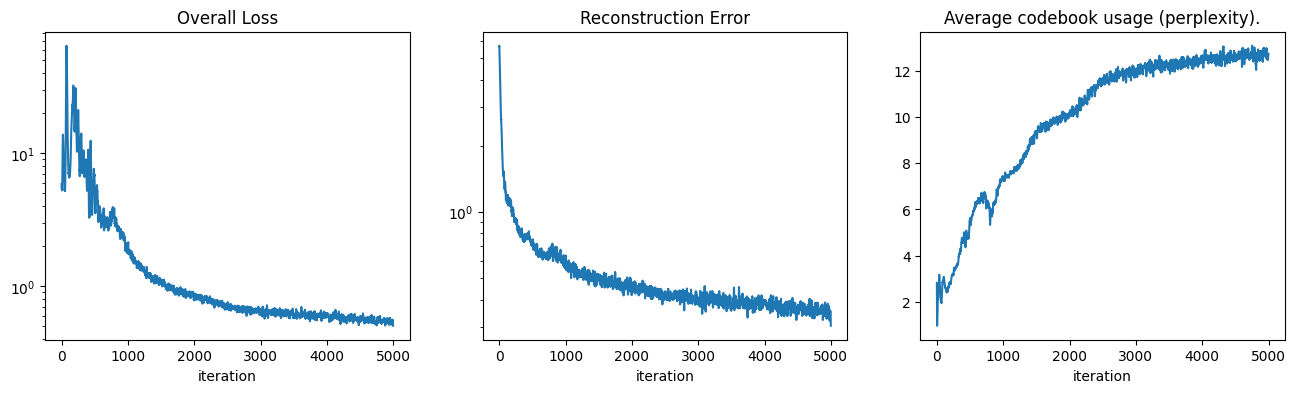

In [79]:
plot_metrics(results=results)

# Validation dataset & Generation of new images

## Validation dataset

In [80]:
import matplotlib.pyplot as plt

def generate_and_display_images(model, test_loader, device):
    with torch.no_grad():
        for idx, (images, _) in enumerate(test_loader):
            images = images.to(device)

            _, reconstructions, _ = model(images)

            images = images.cpu().numpy()
            reconstructions = reconstructions.cpu().numpy()

            images = (images + 1) / 2  
            reconstructions = (reconstructions + 1) / 2

            # Configuration de la figure
            num_images = min(8, images.shape[0])  # 8 images
            fig, axes = plt.subplots(2, num_images, figsize=(15, 5))  

            for i in range(num_images):
                axes[0, i].imshow(images[i, 0], cmap="gray")  
                axes[0, i].axis("off")
                axes[0, i].set_title("Original")

                axes[1, i].imshow(reconstructions[i, 0], cmap="gray") 
                axes[1, i].axis("off")
                axes[1, i].set_title("Reconstruction")

            plt.tight_layout()
            plt.show()

            # Only first batch
            break


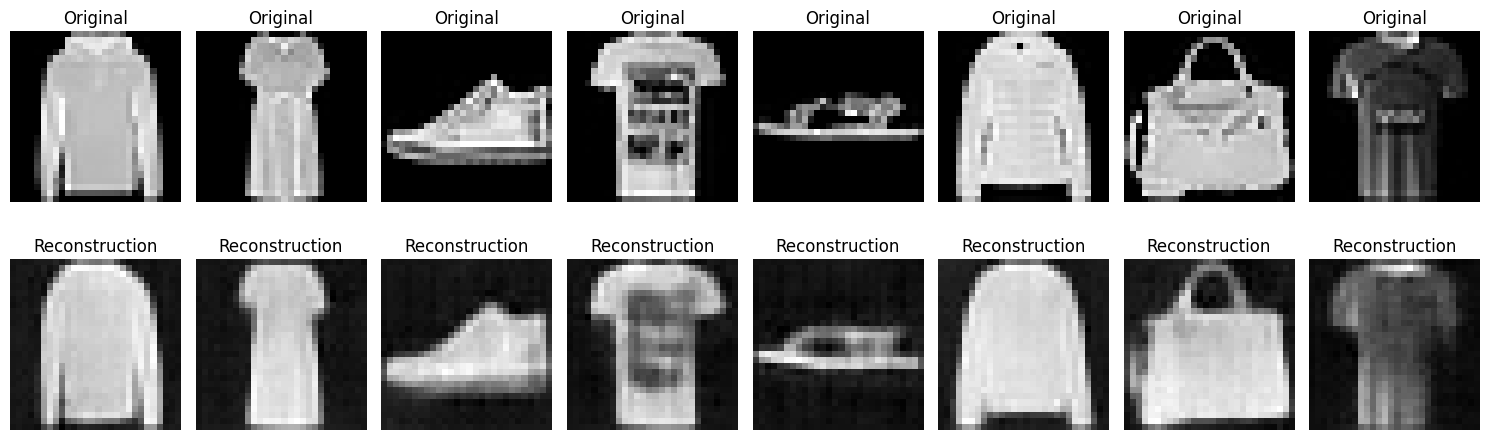

In [81]:
generate_and_display_images(model, val_dataloader, DEVICE)

## Sampling from latent space

In [82]:
def display_image_grid(x):
    x = make_grid(x.cpu().detach()+0.5)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [83]:
num_images = 30
latent_shape = (8, 8)

# Sample random indices from the latent space
sampled_indices = torch.randint(0, n_embeddings, 
                                    size=(num_images, *latent_shape), 
                                    device=DEVICE) 

# Convert indices to embeddings using the codebook
embedding_vectors = model.vector_quantization.embedding.weight[sampled_indices]

# Reshape to match decoder input dimensions (B, C, H, W)
embedding_vectors = embedding_vectors.permute(0, 3, 1, 2)  # Reorder dims (B, H, W, C) -> (B, C, H, W)
    
# Decode the sampled latent vectors into images
generated_images = model.decoder(embedding_vectors)

### Uniform sampling

May be not relevant if distribution in latent space is not uniform

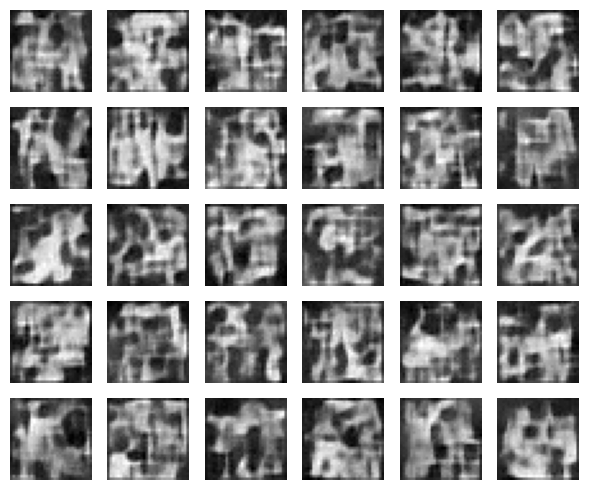

In [84]:
import matplotlib.pyplot as plt

grid_rows = 5 
grid_cols = 6 

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols, grid_rows))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(generated_images):
        ax.imshow(generated_images[i, 0].detach().cpu().numpy(), cmap='gray') 
        ax.axis('off')  
    else:
        ax.axis('off') 

plt.tight_layout()
plt.show()


Even if reconstructed data seem OK in the validation dataset, brand new generated images based on uniform sampling of the latent space does not seem corect.

### Empirical sampling

In [85]:
all_indices = []
for batch in train_dataloader:
    inputs, _ = batch  # batch = (inputs, labels)
    x = inputs.to(DEVICE)  
    z_e = model.encoder(x)  
    _, z_q, _, _, indices = model.vector_quantization(z_e) 
    all_indices.append(indices.cpu().numpy())  

all_indices = np.concatenate(all_indices, axis=0)


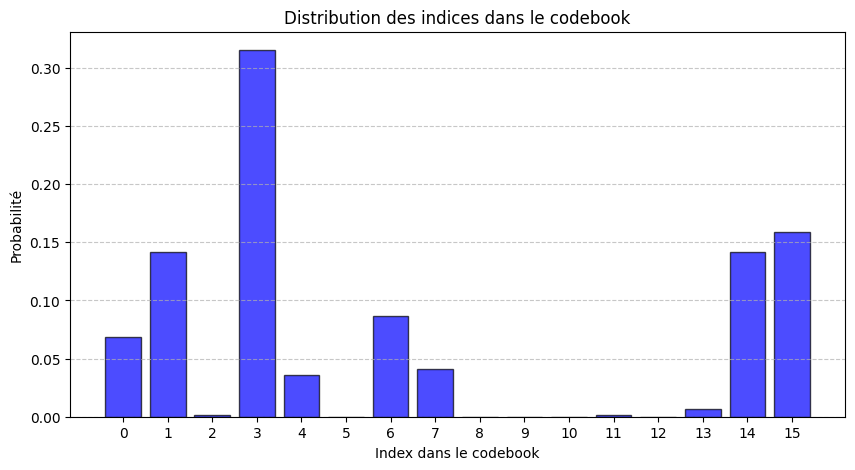

In [ ]:
import matplotlib.pyplot as plt

hist, bin_edges = np.histogram(all_indices, bins=np.arange(n_embeddings + 1), density=True)

probabilities = hist / np.sum(hist)

plt.figure(figsize=(10, 5))
plt.bar(bin_edges[:-1], probabilities, width=0.8, color='blue', alpha=0.7, edgecolor='black')
plt.title("Codebook index distribution")
plt.xlabel("Codebook index")
plt.ylabel("Probability")
plt.xticks(bin_edges[:-1])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [90]:
# Sampling indices based on the histogram
sampled_indices = np.random.choice(
    np.arange(n_embeddings), 
    size=(num_images, *latent_shape),  
    p=probabilities  
)

# Convert indices to embeddings
sampled_indices = torch.tensor(sampled_indices, device=DEVICE)
embedding_vectors = model.vector_quantization.embedding.weight[sampled_indices]
# Reshape and decode
embedding_vectors = embedding_vectors.permute(0, 3, 1, 2)  # (B, H, W, C) -> (B, C, H, W)
generated_images = model.decoder(embedding_vectors)


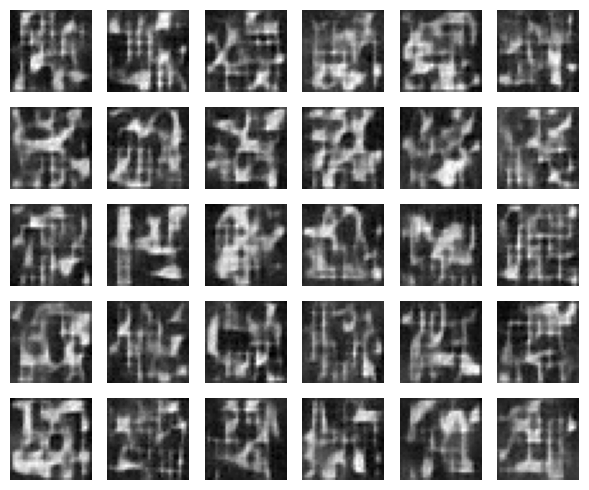

In [91]:
import matplotlib.pyplot as plt

# Parameters for the grid
grid_rows = 5  # Number of rows
grid_cols = 6  # Number of columns

# Create a figure with the specified grid size
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols, grid_rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through each image and plot it in the grid
for i, ax in enumerate(axes):
    if i < len(generated_images):
        ax.imshow(generated_images[i, 0].detach().cpu().numpy(), cmap='gray')  # Assumes single-channel images
        ax.axis('off')  # Turn off axes
    else:
        ax.axis('off')  # Turn off empty subplots

# Adjust spacing
plt.tight_layout()
plt.show()
